<a href="https://colab.research.google.com/github/twilinger/diploma_project/blob/main/translatore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install tensorflow_datasets
#!pip install -U tensorflow-text

In [4]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf
from tensorflow.keras import layers

In [5]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [6]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [7]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
  for ru in ru_examples.numpy():
    print(ru.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


In [8]:
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

train_en = train_examples.map(lambda ru, en: en)
train_ru = train_examples.map(lambda ru, en: ru)

In [9]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

In [10]:
import pathlib
import re

START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def cleanup_text(reserved_tokens, token_txt):
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)


    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [11]:
tokenizers = tf.Module()
tokenizers.ru = CustomTokenizer(reserved_tokens, 'ru_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')

In [12]:
model_name = 'ted_hrlr_translate_ru_en_converter'
tf.saved_model.save(tokenizers, model_name);

In [13]:
reloaded_tokenizers = tf.saved_model.load(model_name)
reloaded_tokenizers.en.get_vocab_size().numpy()

np.int32(7796)

In [14]:
tokens = reloaded_tokenizers.en.tokenize(['Hello TensorFlow!'])
print(tokens.numpy())

round_trip = reloaded_tokenizers.en.detokenize(tokens)
print(round_trip.numpy()[0].decode('utf-8'))

print(tokenizers.en.lookup(tokens))

[[   2 3372 2214  691  952 2669    4    3]]
hello tensorflow !
<tf.RaggedTensor [[b'[START]', b'hello', b'tens', b'##or', b'##f', b'##low', b'!',
  b'[END]']]>


In [15]:
def tokenize_pairs(ru, en):
    ru = tokenizers.ru.tokenize(ru)
    ru = ru.to_tensor()

    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()
    return ru, en

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

In [17]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [18]:
list(train_batches.take(2).as_numpy_iterator())

[(array([[   2,  615,  155, ...,    0,    0,    0],
         [   2,  242,   14, ...,    0,    0,    0],
         [   2,  409,  133, ...,    0,    0,    0],
         ...,
         [   2,   85,  516, ...,    0,    0,    0],
         [   2,  107, 2718, ...,    0,    0,    0],
         [   2,  156, 3916, ...,    0,    0,    0]]),
  array([[  2, 103, 208, ...,   0,   0,   0],
         [  2,  85,  95, ...,   0,   0,   0],
         [  2, 103,  93, ...,   0,   0,   0],
         ...,
         [  2,  85, 179, ...,   0,   0,   0],
         [  2,  47, 501, ...,   0,   0,   0],
         [  2, 128,  39, ...,   0,   0,   0]])),
 (array([[   2,  130, 2551, ...,    0,    0,    0],
         [   2,   85,  107, ...,    0,    0,    0],
         [   2,  134,  161, ...,    0,    0,    0],
         ...,
         [   2,  958,   15, ...,    0,    0,    0],
         [   2,   85,  139, ...,    0,    0,    0],
         [   2,  363, 3581, ...,    0,    0,    0]]),
  array([[   2,   90,    9, ...,    0,    0,    0],

In [19]:
def get_angles(pos, i , d_model):
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis,:],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 25, 512)


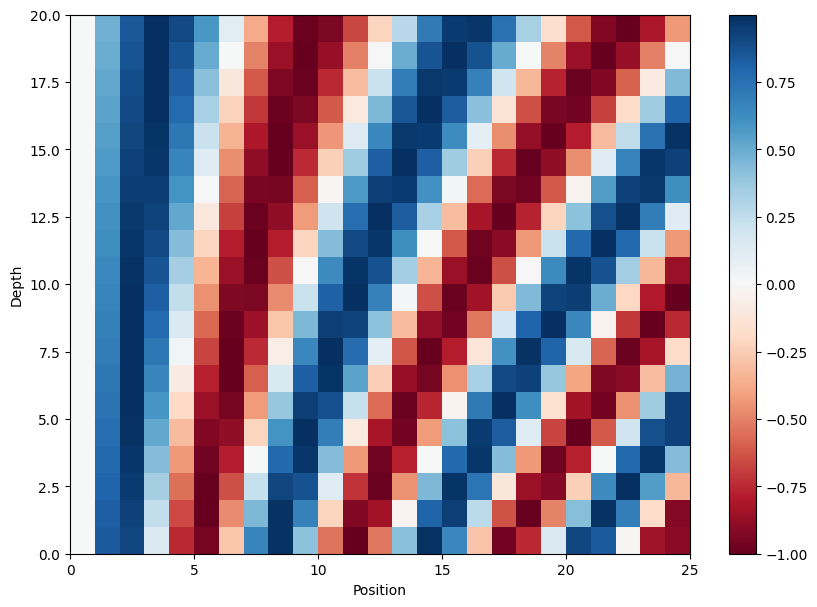

In [20]:
n, d = 25, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.pcolormesh(pos_encoding[:20,:], cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [21]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :] #(batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [22]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [23]:
a = tf.ones((3,3))
tf.linalg.band_part(a, 0, 0)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)

    attention_logits = tf.matmul(q, k, transpose_b=True)

    scaled_attention_logits = attention_logits / tf.math.sqrt(d_k)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [25]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(np.round(temp_attn, decimals=2))
    print('Output is:')
    print(np.round(temp_out, decimals=2))

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
[[0. 1. 0. 0.]]
Output is:
[[10.  0.]]


In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model  // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)

        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        The inputs need to be reshaped in order to be fed into the attention portion.
        The model dimension d_k get split into heads x depth.
        Then transposed to (batch_size, num_heads, seq_len, depth)

        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [27]:
tf.random.set_seed(42)
mha = MultiHeadAttention(512, 8)

x = tf.ones((1,60, 512))
out, attn = mha(x,k=x,q=x, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [28]:
def point_wise_feed_forward_network(d_model, d_ff):
    return tf.keras.Sequential([layers.Dense(d_ff, activation='relu'),
                                layers.Dense(d_model)])

In [29]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, d_ff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        attn_out, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_out = self.dropout1(attn_out, training=training)
        out1 = self.layernorm1(x + attn_out)

        ff_out = self.ffn(out1)
        ff_out = self.dropout2(ff_out, training=training)
        out2 = self.layernorm2(out1 + ff_out) # (batch_size, input_seq_len, d_model)

        return out2



In [34]:
tf.random.set_seed(42)
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)),  # input tensor
    training=False,  # pass as keyword argument
    mask=None  # pass as keyword argument
)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [38]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, d_ff, dropout_rate)
                            for i in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, training, mask):

      x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :tf.shape(x)[1], :]

      for i in range(self.num_layers):
          x = self.enc_layers[i](x, training=training, mask=mask)
      return x

In [39]:
tf.random.set_seed(42)
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         d_ff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input,
                                       training=False,
                                       mask=None)
print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [40]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mmha = MultiHeadAttention(d_model, num_heads)
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, d_ff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)

    def call(self, x, encoder_out, training, look_ahead_mask, padding_mask):
        mask_attn_out, attn_weights_block1 = self.mmha(x, x, x, look_ahead_mask) # (batch_size, target_seq_len, d_model)
        mask_attn_out = self.dropout1(mask_attn_out, training=training)
        out1 = self.layernorm1(mask_attn_out + x)

        attn_out, attn_weights_block2 = self.mha(encoder_out, encoder_out,
                                                 out1, padding_mask)
        attn_out = self.dropout2(attn_out, training=training)
        out2 = self.layernorm2(attn_out + out1)

        ff_out = self.ffn(out2)
        ff_out = self.dropout3(ff_out, training=training)
        out3 = self.layernorm3(ff_out + out2) # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [46]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ff, target_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, d_ff, dropout_rate)
                            for i in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]

      for i in range(self.num_layers):
          x, block1, block2 = self.dec_layers[i](
              x, enc_output,
              training=training,  # Pass as keyword argument
              look_ahead_mask=look_ahead_mask,  # Pass as keyword argument
              padding_mask=padding_mask  # Pass as keyword argument
          )
          attention_weights[f'decoder_layer{i+1}_block1'] = block1
          attention_weights[f'decoder_layer{i+1}_block2'] = block2

      return x, attention_weights  # (batch_size, target_seq_len, d_model)

In [47]:
tf.random.set_seed(42)
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         d_ff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [52]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, dropout_rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff,
                            input_vocab_size, pe_input, dropout_rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff,
                            input_vocab_size, pe_target, dropout_rate)

        self.final_layer = layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)  # Fixed
        dec_output, attention_weights = self.decoder(
            tar,
            enc_output,
            training=training,
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [53]:
tf.random.set_seed(42)
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, d_ff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)


TensorShape([64, 36, 8000])

In [50]:
num_layers = 4
d_model = 128
d_ff = 512
num_heads = 8
dropout_rate = 0.1

In [51]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        lr = tf.math.rsqrt(self.d_model) * tf.math.minimum(tf.math.rsqrt(step),
                                                           step*self.warmup_steps**-1.5)

        return lr
learning_rate = CustomSchedule(d_model)

Text(0.5, 0, 'Train Step')

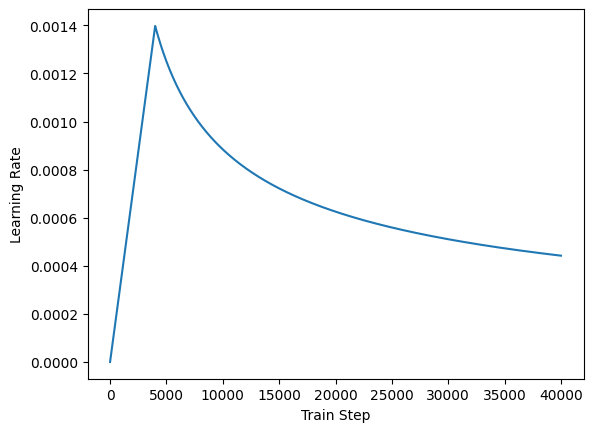

In [54]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)